In [2]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import radius_neighbors_graph

import seaborn as sns

from matplotlib.pyplot import rc_context
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

import pySTIM as pst

import warnings
warnings.filterwarnings('ignore')
cmap = mcolors.LinearSegmentedColormap.from_list('WhRd',['#ffffff', "#fffacd", "red", "darkred"], N=256)  

/home/spatial/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
adata = sc.read_h5ad("../Xenium_all.h5ad")

Figure 4A

In [ ]:
radius = 55/2
neighbors_dict = {}
cell_idx = []

samples = list(adata.obs.ident.cat.categories)

for index in range(0, len(samples)):
    print(samples[index])
    tmp = adata[adata.obs.ident==samples[index]]
    cell_idx = cell_idx + list(adata[adata.obs.ident==samples[index]].obs_names)
    x_y_coordinates = np.array(tmp.obs[["x_centroid","y_centroid"]])
    cts =  np.array(tmp.obs["celltype_plot"])
    cts[(cts=="MTAL") | (cts=="CTAL")] = "TAL"
    
    connectivity_matrix = radius_neighbors_graph(x_y_coordinates, radius, mode='connectivity', include_self=False)
    one_hot_matrix = pd.get_dummies(cts).values
    cell_by_neighborhood_matrix = connectivity_matrix.dot(one_hot_matrix)

    cell_type_columns = pd.get_dummies(cts).columns
    cell_by_neighborhood_df = pd.DataFrame(cell_by_neighborhood_matrix, columns=cell_type_columns)

    row_sums = cell_by_neighborhood_df.sum(axis=1)
    cell_by_neighborhood_df = cell_by_neighborhood_df.div(row_sums, axis=0)
    cell_by_neighborhood_df.fillna(0, inplace=True)
    cell_by_neighborhood_df["cell_type"] = cts
    cell_by_neighborhood_df["sample"] = samples[index]
    cell_by_neighborhood_df[["x","y"]] = x_y_coordinates
    cell_by_neighborhood_df["ident"] = samples[index][:-1]
    neighbors_dict[samples[index]] = cell_by_neighborhood_df

In [ ]:
all_neighbors_df = pd.concat(neighbors_dict.values())

n_neighborhoods = 20
k_centroids = {}

values = np.array(all_neighbors_df.iloc[:,:-5])
km = MiniBatchKMeans(n_clusters = n_neighborhoods, random_state=0)
labelskm = km.fit_predict(values)
k_centroids[20] = km.cluster_centers_

## calculate enrichment
niche_clusters = (k_centroids[20])
cell_types = all_neighbors_df.columns[:-6]
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc, columns = cell_types, index = ["CN_"+ str(i) for i in range(20)])

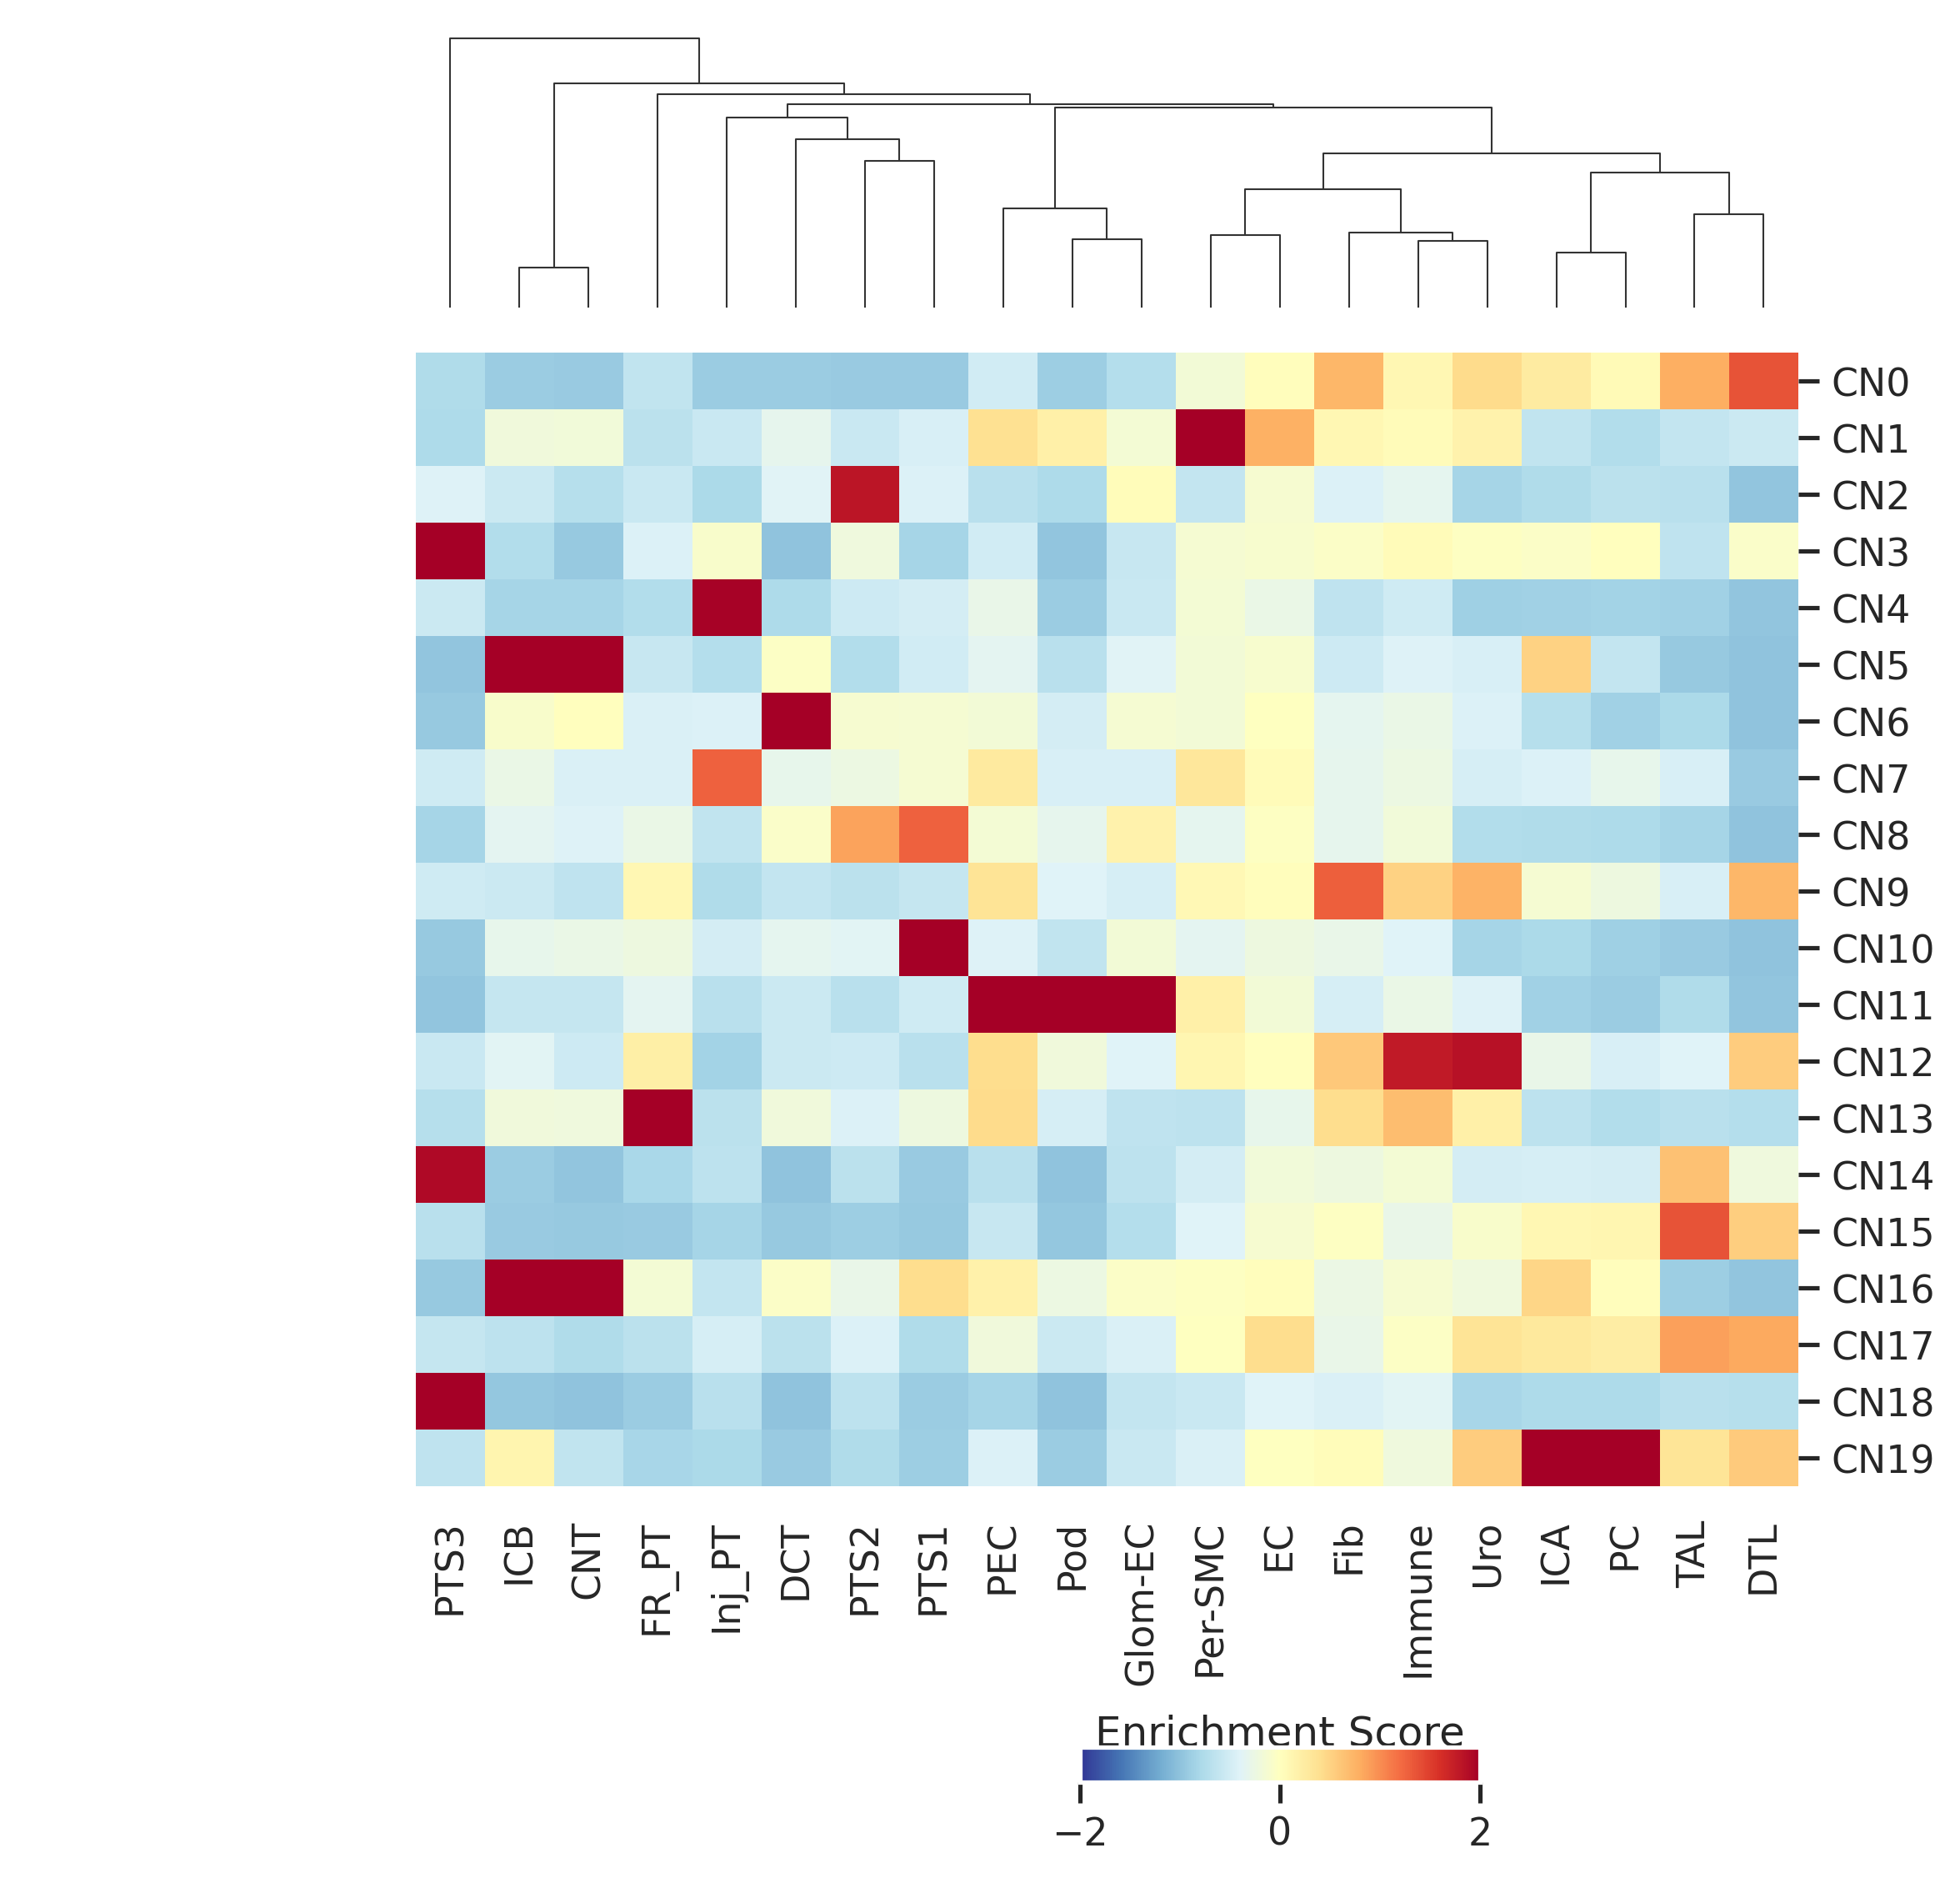

In [56]:
sns.set(font_scale=1.4, rc={"figure.dpi":300, 'savefig.dpi':300})
g = sns.clustermap(fc, vmin=-2, vmax=2, cmap="RdYlBu_r", cbar_pos=None, row_cluster=False, figsize=(8,7))
g.ax_heatmap.yaxis.tick_left() 
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)


fig = g.fig
cbar_ax = fig.add_axes([0.55, -0.01, 0.2, 0.02])  
norm = Normalize(vmin=-2, vmax=2)
cbar = ColorbarBase(cbar_ax, cmap="RdYlBu_r", norm=norm, orientation='horizontal')
plt.tight_layout()
plt.show()

In [99]:
clusters_to_merge = [[0, 15, 17],
                     [1, 11],
                     [2, 8, 10],
                     [3, 14, 18],
                     [4, 7],
                     [5, 16, 19],
                     [6],
                     [9, 13],
                     [12]]

In [100]:
new_centroids = []
for group in clusters_to_merge:
    group_centroids = niche_clusters[group]  
    mean_centroid = np.mean(group_centroids, axis=0)  
    new_centroids.append(mean_centroid)
    
new_centroids = np.array(new_centroids)

In [101]:
new_centroids.shape

(9, 20)

In [102]:
values = np.array(all_neighbors_df.iloc[:,0:20])
tissue_avgs = values.mean(axis = 0)

In [103]:
fc = np.log2(((new_centroids+tissue_avgs)/(new_centroids+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc, columns = cell_types, index = ["CN"+ str(i) for i in range(9)])

In [106]:
reorder_columns = ['TAL','DTL','Pod','Glom-EC','Per-SMC','PEC','PTS1','PTS2',
                   'PTS3', 'Inj_PT','ICB','CNT','ICA','PC','DCT', 
                   'FR_PT','Fib','Immune','Uro','EC']
fc = fc.loc[:,reorder_columns]

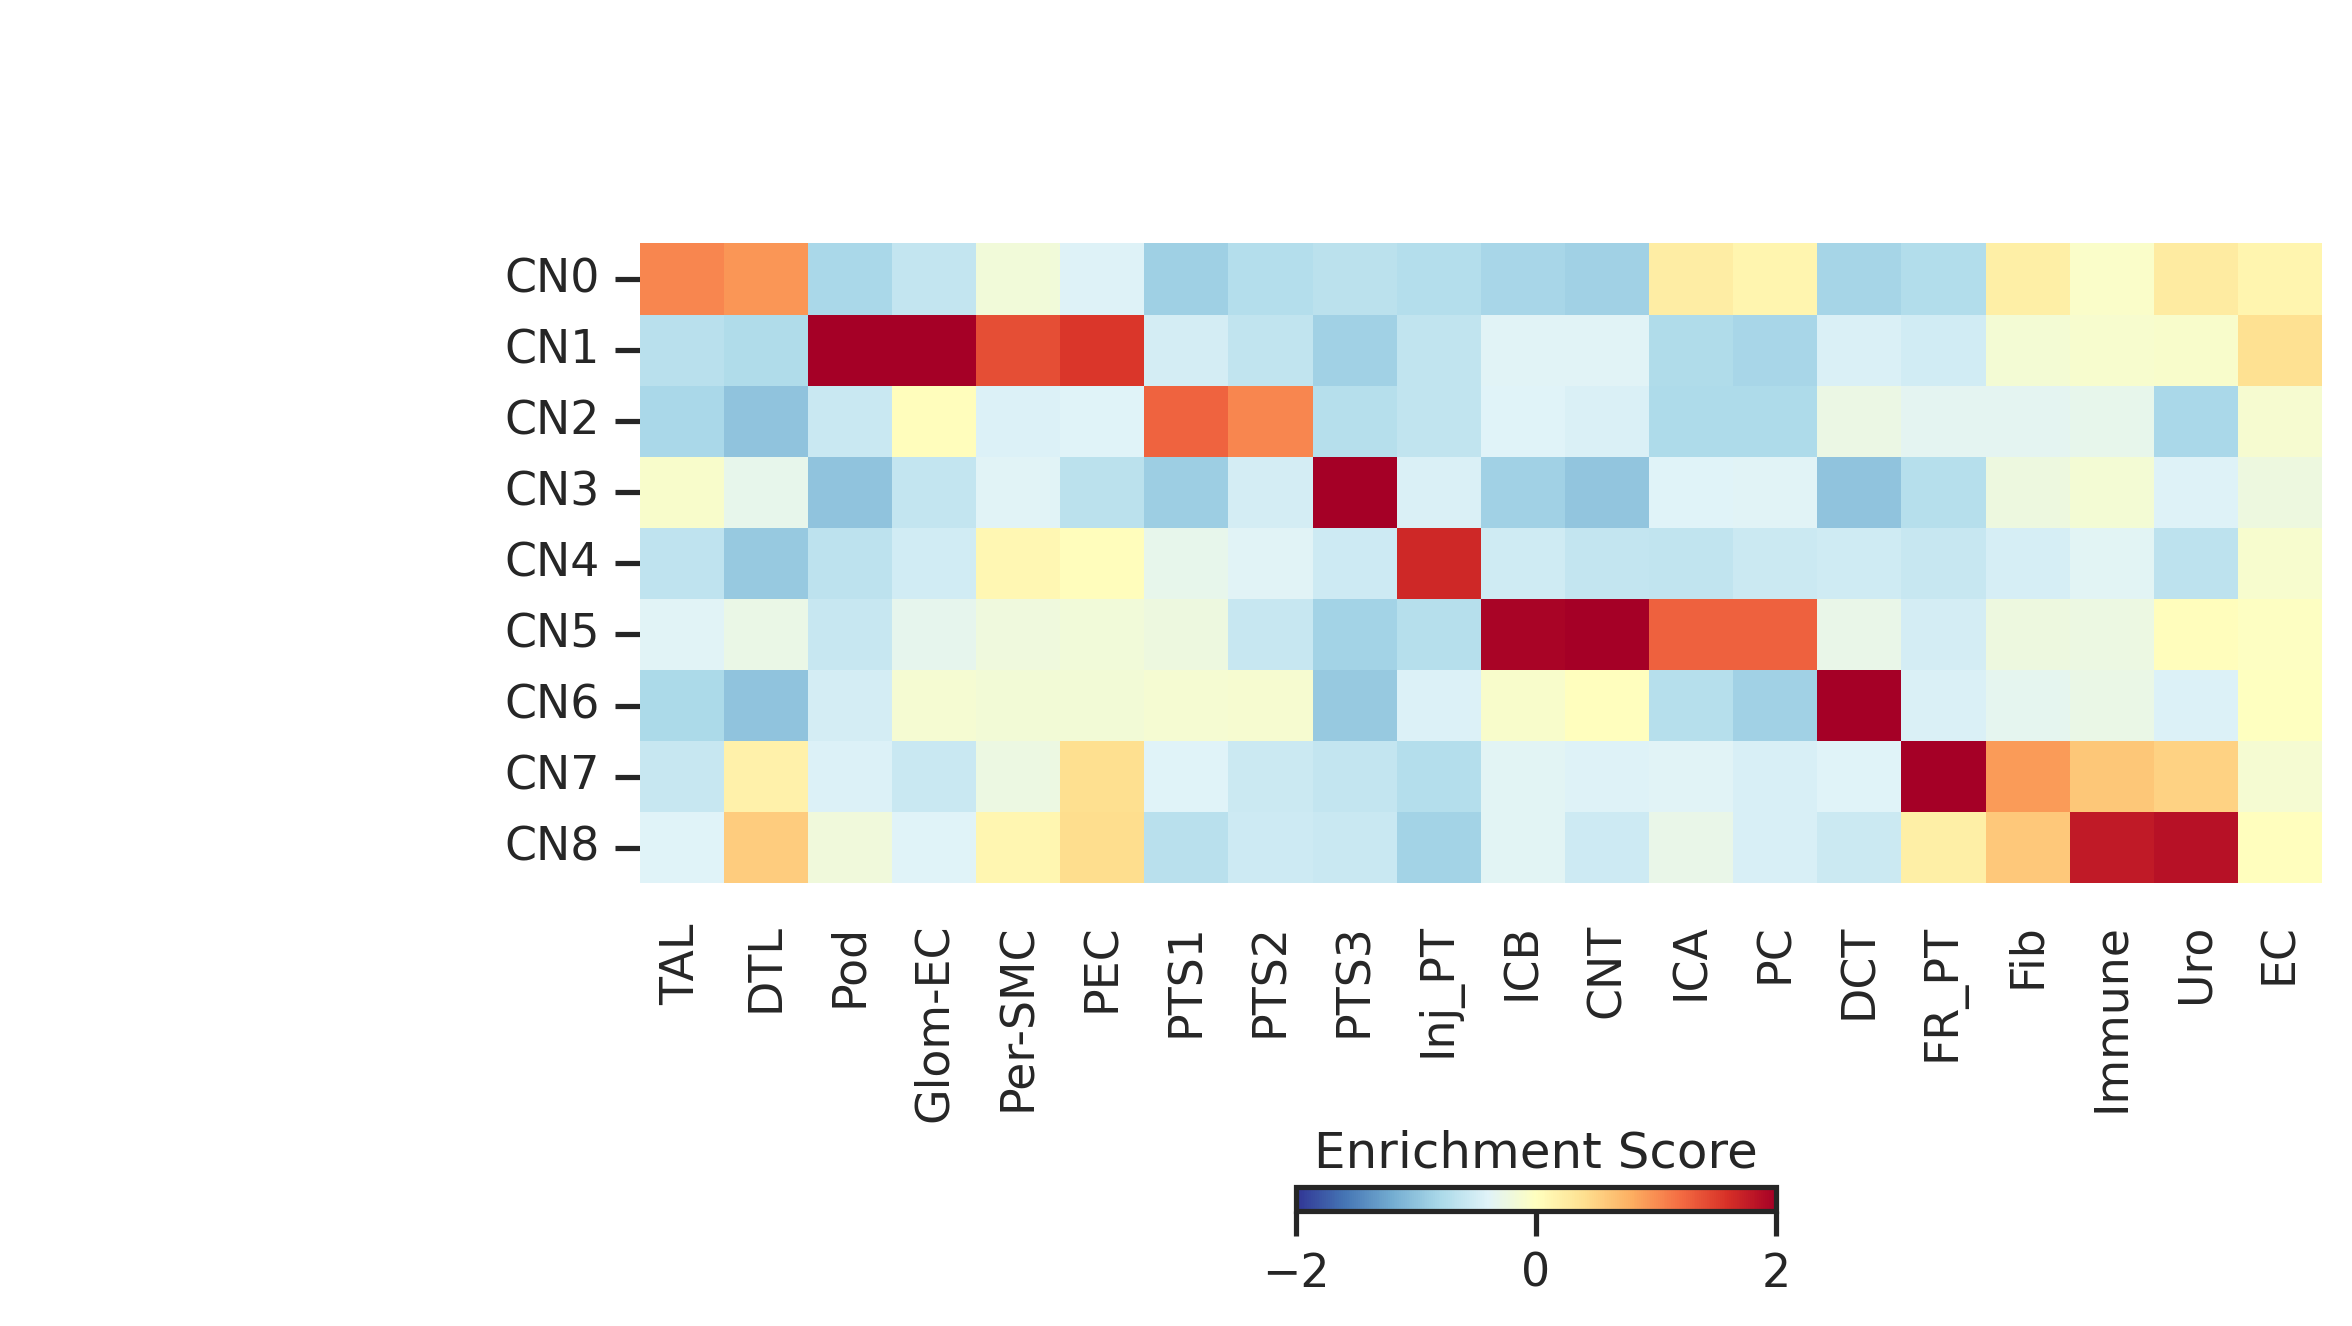

In [215]:
g = sns.clustermap(fc, vmin=-2, vmax=2, cmap="RdYlBu_r", cbar_pos=None, 
                   row_cluster=False, col_cluster=False, figsize=(8,4))

g.ax_heatmap.yaxis.set_label_position("right")
g.ax_heatmap.yaxis.tick_left()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

# Add an Axes for the colorbar
fig = g.fig
cbar_ax = fig.add_axes([0.55, -0.03, 0.2, 0.02])  # Adjust these values as needed for your layout
# Create the colorbar
norm = Normalize(vmin=-2, vmax=2)
cbar = ColorbarBase(cbar_ax, cmap="RdYlBu_r", norm=norm, orientation='horizontal')
cbar.set_label('Enrichment Score', labelpad=-40, horizontalalignment='center')

plt.tight_layout()
plt.show()

Figure 4C

In [ ]:
## CN Visualization
pst.plot_scatter(adata[adata.obs.ident == "ShamR"], xlims=[1850,2150], ylims=[500,1400], dpi=200, ptsize=15,
                    color_by='CN', seed=123, alpha=1, ticks=False, 
                    width = 5, height = 5, save = "sham_CN.png")
pst.plot_scatter(adata[adata.obs.ident == "Hour4R"], xlims=[2700,3000], ylims=[3200,4100], dpi=200, ptsize=15,
                    color_by='CN', seed=123, alpha=1, ticks=False, 
                    width = 5, height = 5, save = "hour4_CN.png")                
pst.plot_scatter(adata[adata.obs.ident == "Hour12R"], xlims=[2300,2600], ylims=[1450,2350], dpi=200, ptsize=15,
                    color_by='CN', seed=123, alpha=1, ticks=False, 
                    width = 5, height = 5, save = "hour12_CN.png")
pst.plot_scatter(adata[adata.obs.ident == "Day2R"], xlims=[2700,3000], ylims=[600,1500], dpi=200, ptsize=15,
                    color_by='CN', seed=123, alpha=1, ticks=False, 
                    width = 5, height = 5, save = "day2_CN.png")
pst.plot_scatter(adata[adata.obs.ident == "Day14R"], xlims=[1600,1900], ylims=[3500,4400], dpi=200, ptsize=15,
                    color_by='CN', seed=123, alpha=1, ticks=False, 
                    width = 5, height = 5, save = "day14_CN.png")
pst.plot_scatter(adata[adata.obs.ident == "Week6R"], xlims=[1120,1420], ylims=[3650,4550], dpi=200, ptsize=15,
                    color_by='CN', seed=123, alpha=1, ticks=False, 
                    width = 5, height = 5, save = "week6_CN.png")
                